Imports and ignore future warnings

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import datetime as dt
import yfinance as yf
from concurrent.futures import ThreadPoolExecutor

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from utils.calculations_simply import *
from utils.df_operations import *
from utils.yahoo_queries import *

##### Simple pull of SPX names from wiki, slight correction in names with '-' instead of '.'

In [4]:
html = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = BeautifulSoup(html.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

In [5]:
stock_data = pd.read_html(str(table))[0]
names = [name.replace(".", "-") for name in stock_data.Symbol]
name_query = " ".join(names)

##### Download prices and returns for our universe of names for 1 business month

In [6]:
delta_t = pd.tseries.offsets.BusinessDay(n = 21)
end_date = dt.date.today()
start_date = end_date - delta_t

In [7]:
px = yf.download(name_query, start=start_date)
rets = px.pct_change(1)

[*********************100%***********************]  503 of 503 completed


##### Convert to ticker format such that we can call in threaded format

In [8]:
tickers = yf.Tickers(name_query)

In [9]:
thread_count = 50
name_count = 500

thread_loop = []

with ThreadPoolExecutor(thread_count) as executor:
    futures = [executor.submit(exp_retrieve, name, thread_loop, tickers) for name in names[:name_count]]
    
with ThreadPoolExecutor(thread_count) as executor:
    futures = [executor.submit(option_retrieve, tick, name, exp, px, rets) for tick, name, exp in thread_loop]
    
opt_chain = pd.concat([future.result() for future in futures]).sort_values(['ticker', 'expiry']).reset_index(drop = True)

##### Calculate vol and delta values and insert into frame.

1. Data is sparse in some cases, be it during some time of day or just a poor population on the yahoo side
2. We will address this in future by finding best time to query and method to incrementally populate with best data

In [11]:
test_chain = get_delta_values(opt_chain)
test_chain = test_chain[test_chain['callput'] == 'call']

/Users/benjaminbowring/Desktop/Coding/OptionSite/utils/calculations_simply.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(s / k) + (R + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))


In [12]:
rebase_index = np.arange(0.8,1.21,0.01)

##### Out of interest seeing the top 10 liquid names for the last trading day

In [20]:
pd.DataFrame(test_chain.groupby('ticker')['volume'].sum().sort_values(ascending=False)[:100]).index

Index(['BMY', 'AAPL', 'F', 'AMZN', 'DIS', 'T', 'BAC', 'META', 'CCL', 'PYPL',
       'TSLA', 'C', 'GOOGL', 'GOOG', 'NVDA', 'MSFT', 'NCLH', 'WFC', 'INTC',
       'MU', 'AIG', 'WBD', 'NEE', 'AMD', 'MS', 'PFE', 'MET', 'NFLX', 'GS',
       'JPM', 'VZ', 'GM', 'UPS', 'GE', 'CSCO', 'NKE', 'DVN', 'LVS', 'FCX',
       'KMI', 'XOM', 'EOG', 'OXY', 'NEM', 'ORCL', 'PARA', 'CTRA', 'GILD',
       'COP', 'FSLR', 'CVX', 'DISH', 'PCG', 'KHC', 'MO', 'BIIB', 'CRM', 'AFL',
       'QCOM', 'SCHW', 'ABT', 'V', 'BA', 'IBM', 'VTRS', 'DAL', 'HWM', 'WMT',
       'MTCH', 'MRNA', 'UAL', 'AAL', 'SBUX', 'AKAM', 'WYNN', 'AVGO', 'BK',
       'RCL', 'EXC', 'AMAT', 'EBAY', 'LUMN', 'ADBE', 'WBA', 'CPRT', 'TSN',
       'HBAN', 'ATVI', 'BRK-B', 'CF', 'CZR', 'OKE', 'HAL', 'KEY', 'DHI', 'MRK',
       'TMUS', 'HD', 'VLO', 'SO'],
      dtype='object', name='ticker')

In [15]:
ticks = [name for name in test_chain.groupby('ticker')['volume'].sum().sort_values(ascending=False)[:10].index]
d_curve = test_chain[(test_chain['ticker'].isin(ticks)) & (test_chain['expiry'] == '2023-01-20') & (test_chain['callput'] == 'call')]

##### Interpolate live options onto fractional strike prices so we can get a full surface

* In some cases impossible to avoid ugly surfaces due to poor population, as data is non-historic this is unavoidable and we will find ways to incrementally improve with multiple queries

In [16]:
curves = pd.DataFrame()

curve_df = pd.DataFrame(columns = ticks, index = rebase_index)

for tick in ticks:
    
    t_curve = d_curve[d_curve['ticker'] == tick][['k_norm', 'delta_calc']].set_index('k_norm')

    interp_curve = pd.DataFrame(np.interp(rebase_index, t_curve.index, t_curve.delta_calc), index = rebase_index)

    curve_df[tick] = interp_curve

##### Curves look shocking in some cases due to low liquidity

<AxesSubplot: >

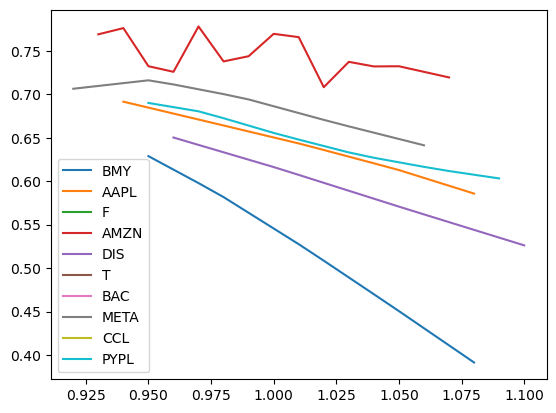

In [17]:
curve_df.plot()

Functional delta calcs from live data, but the absolute state of it means Ill probably try out a data provider for a month

<AxesSubplot: >

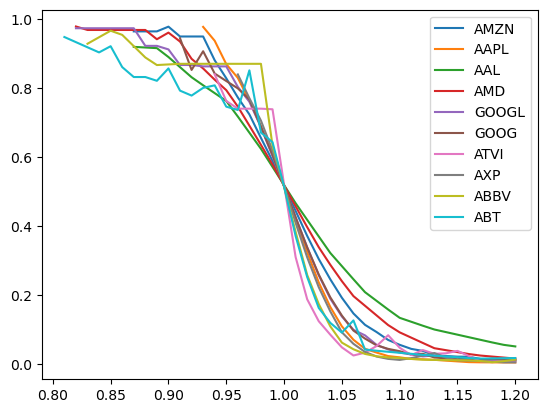

In [45]:
curve_df.ffill().plot()